# BEBI5009 Homework 5

Student: Shao-Ting Chiu

Student ID: B03901045

Source Code on Github: https://github.com/stevengogogo/BEBI-5009-Modeling-and-Simulation-in-Systems-Biology

Reference: B. P.Ingalls, Mathematical Modelling in Systems Biology : An Introduction, vol. 53, no. 9. 2014.

## Problem 1 - Noise-induced oscillation

<img src = "img/hw5_p1.png">

## 1.(a) Simulation by Gillepie algorithm and First-reaction method

<img src = "img/hw5_p1a.png">

<img src = "img/hw5_p1a_som.png">

* __Proof of First-reaction method__:
    
    * Sampling by summation of propensities: 
    $$P(0<T_{sum}<t) = 1 - e^{-\alpha t}$$

    * Sampling by the first-reaction method: 
    $$T_{wait}=min(T_1,...,T_m)$$
    where $P(0<T_i<t) = 1-e^{-\alpha_{i}t}$ 
    
    
    We need to show that $P(0 < T_{wait} < t) = P(0 < T_{sum} < t)$ ,
    
\begin{align}
P(0<T_{wait}<t) &= 1 - P(T_{wait} \geq t) \\
                &= 1 - P(min\{T_1,...,T_m\} \geq t) \\
                &= 1 - P(T_1 \geq t \cap ... \cap T_m) \\
\end{align}

Because $T_i,...,T_m$ are independent variables,

\begin{align}
P(0<T_{wait}<t) &= 1 - P(T_1 \geq t)...P(T_m \geq t) \\
                &= 1 - \bigcap_{i=1}^{m}P(T_{i} \geq t) \\
                &= 1 - \bigcap_{i=1}^{m}(1-(1-e^{-\alpha_{i} t})) \\
                &= 1 - \bigcap_{i=1}^{m}e^{-\alpha_{i} t} \\
                &= 1 - e^{-(\sum_{i}^{m}\alpha_{i}t)} \\
                &= 1 - e^{-\alpha t} \\
                & = P(0<T_{sum}<t) \\
\end{align}
    
    

* __Parameters__:

|Parameter|Value|Notation in code|
|---|---|---|
|$\gamma_{A}$|250|y_a|
|$b_{A}$|5|b_a|
|$K_A$|0.5|k_a|
|$\alpha_0$|0.1|a_0|
|$\delta_{A}$|1|d_a|
|$\gamma_R$|50|y_r|
|$b_R$|10|b_r|
|$K_R$|1|k_r|
|$K_c$|200|k_c|
|$\delta_R$|0.1|d_r|

* __Variables__:

$$A + R -> C$$

|Variable|Initial Value|Notation in code|
|---|---|---|
|A|0|N_A|
|R|0|N_R|
|C|0|N_C|


* __Vector & Matrix__:

|Matrix|Content|Notation in code|
|---|---|---|
|$\vec{N}$|State vector: $[N_1,...,N_u]^{T}$|N|
|$\textbf{S}$|Stoichiometry matrix $[\vec{S_1},...,\vec{S_v}]$|s|
|$\vec{a}$|Propensity vector: $[a_1,...,a_v]^{T}$|a|

where $u$, and $v$ are numbers of total chemicals and reactions


* *Think further: how to sample exponential distribution by uniform distribution([page 19 in ref](http://q-bio.org/w/images/3/37/Slides-Munsky.pdf))*:
   
    we needs to sample $T_{wait} \sim exp(\alpha)$, and we may need a way to generate it from $R \sim Uniform(0,1)$ which is the more common. It is important to re-state the cumulative function again:
    
    * $P(0 \leq T_{wait} \leq t) = 1 - e^{-\alpha t}$
    
    * $P(0 \leq R \leq r) = r$
    
    * Lemma: if $\tau = \frac{1}{\alpha} ln(\frac{1}{R})$, then $\tau \sim exp(\alpha)$
    
        * Proof:
    
    \begin{align}
    P(0 \leq \tau \leq t) &= P(0 \leq \frac{1}{\alpha} ln(\frac{1}{R}) \leq t) \\
                          &= P(0 \leq ln\frac{1}{R} < \alpha t) \\
                          &= P(1 \leq \frac{1}{R} \leq e^{\alpha t}) \\
                          &= P(e^{-\alpha t} \leq R \leq 1) \\
                          &= 1 - e^{-\alpha t} \\
    \end{align}
        * Therefore, $\tau \sim exp(\alpha)$


### Define stochastic reaction

In [3]:
def stochastic_reaction(N, K):
    """
    Stochastic Reaction 
    
    Arguments:
            N: state vector. [N_A, N_B, N_C]
            K: constant vector. 
            
    Return:
            s: stoichiometry matrix [reaction_index, agent_index]
            a: propensity vector [a_1,.., a_v]
    
    """
    N_A, N_R, N_C = N
    y_a, b_a,k_a,a_0,d_a,y_r,b_r,k_r,k_c,d_r = K
    
    # Define stoichiometry matrix: state vector [R_1,...,R_v]
    # R_i = [dn_1,...,dn_u]
    s = np.array([
                 [b_a,0,0],
                 [0,b_r,0],
                 [-1,0,0],
                 [0,-1,0],
                 [-1,-1,1],
                 [0,1,-1]
                ])
    
    # Define propensity vector
    a = np.array([
                  (y_a / b_a) * (a_0 + N_A / k_a) / (1 + N_A / k_a),
                  (y_r / b_r) * (N_A/k_r)/(1 + N_A/k_r),
                   d_a * N_A,
                   d_r * N_R,
                   k_c * N_A * N_R,
                   d_a * N_C
                ])
    return s, a

### Define Stochastic Simulation Alogrithm (SSA)

* Reference: [python3.6 Class operation basics](https://docs.python.org/3.6/tutorial/classes.html)

In [4]:
import numpy as np
# Set inital state N
N_A0, N_R0, N_C0 = 0, 0, 0
N = np.array([N_A0, N_R0, N_C0])

class SSA:
    
    def __init__(self, stochastic_reaction, N, K, t_max=100, samp_rate=1, method='first-reaction',):
        self.stochastic_reaction = stochastic_reaction
        
        # History of state vector
        self.N = N
        
        # Constants
        self.K = K
    
        # T_max
        self.t_max = t_max
        
        # History of time
        self.t = [0]
        
        # Histroy of reaction index
        self.r = []
        
        # Samp_rate
        self.h = samp_rate
        
        # Method
        self.method = method
    
    def __iter__(self):
        return self
    
    def __next__(self):
        s, a = self.stochastic_reaction(self.N, self.K)
        
        if self.method == 'first-reaction':
            t_wait, r_nexti = self.samp_expFirst(a)
        elif self.method == 'gill':
            t_wait, r_nexti = self.samp_expDirect(a)
        else:
            raise ValueError
        
        # Forward time t
        self.t.append(self.t[-1] + t_wait)
        
        # Stop iteration once t > t_max
        if self.t[-1] >= self.t_max:
            raise StopIteration
        
        # Forward reaction i
        self.N = self.N + s[r_nexti]
        
        return self.N, self.t[-1]
    
    def hazards(self, a):
        return self.h * a
    
    def samp_expFirst(self, a):
        '''
        Sampling exponential distribution with propensity c
        Arguments:
                s: stoichiometry vector
                a: propensity vector
        Returm: 
                t_wait: min of t_wait sampling of reactions
                r_nexti: index of next reaction
        '''
        # Report stoichiometry vector and propensity vector
        
        # Sampling waiting times
        t_waits_samp = []
        index = 0
        
        # Rescale hazards with h = 1
        a = self.hazards(a)
        for a_i in a:
            
            # avoid 1/p = 1/0
            if a_i == 0.0: 
                # set infinity as -1
                t_waits_samp.append(-1)
                continue
                
            r = np.random.uniform(0,1)
            
            # avoid 1/r = 1/0
            while r == 0.0:   
                r = np.random.uniform(0,1)
                    
            # probability rescale
            t_waits_samp.append((1 /a_i) * np.log(1 / r))
            
        
        # determine t_wait and next reaction
        t_wait, r_nexti = self.choose_positive_min(t_waits_samp)
        
        return t_wait, r_nexti
    
    def samp_expDirect(self, a):
        # Two random variables
        r = np.random.uniform(0,1)
        t = np.random.uniform(0.0001,1)
        num = np.sum(a)
        i = 0
        # Cumulation of propensities ratio
        cum_p = 0
        for a_i in a:
            cum_p += a_i
            if r < cum_p:
                break
            i += 1
        
        return (1/num) * np.log(1/t), i 
            
    
    def choose_positive_min(self, array):
        unsort_arr = array
        array = np.asarray(array)
        sorted_i = array.argsort()
        array.sort()
        nonzero_i = np.where(array > 0)
        arg_mini = sorted_i[nonzero_i[0][0]]
        positive_mini = unsort_arr[arg_mini]
        return positive_mini, arg_mini
            

## Stochastic simulation

In [5]:
# Set parameters
param = {
    'N':[10,10,35],
    'K':[250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.1]
}

# Set simulation class
sim = SSA(stochastic_reaction, **param, t_max=1, samp_rate=4, method='first-reaction')

# Run iteration and stored results
N = np.array([])
t = np.array([])
for i, j in sim:
    N = np.append(N,i)
    t = np.append(t, j)
    
N = N.reshape(-1,len(t))

## Plot stochastic simulation

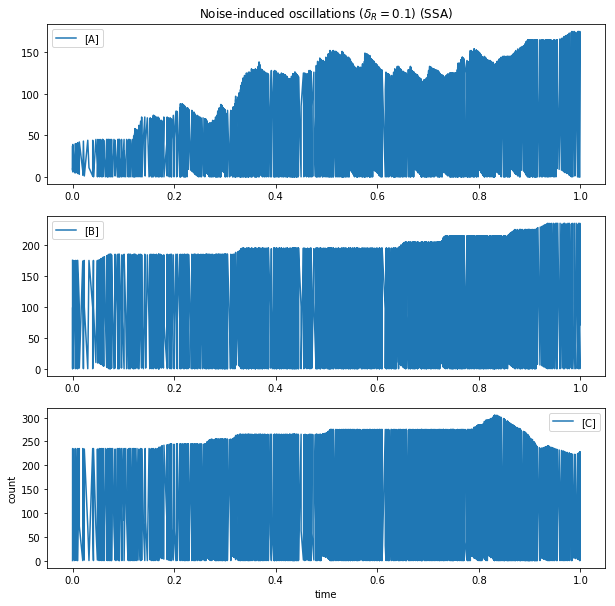

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(t, N[0,:], label='[A]')
plt.title('Noise-induced oscillations ($\delta_R=0.1$) (SSA)')
plt.legend()

plt.subplot(312)
plt.plot(t, N[1,:], label='[B]')
plt.legend()

plt.subplot(313)
plt.plot(t, N[2,:], label='[C]')
plt.legend()
plt.xlabel('time')
plt.ylabel('count')
plt.show()

### Conclusion of 1.(a)

1. It behaves in the pattern of quasi-periodic behavior.

## 1.(b) Deterministic simulation

<img src = "img/hw5_p1b.png">

### Define deterministic reaction

In [7]:
def deterministic_reaction(N, t, K):
    N_A, N_R, N_C = N
    y_a, b_a,k_a,a_0,d_a,y_r,b_r,k_r,k_c,d_r = K
    
    dfdt = [
        (y_a) * (a_0 + N_A / k_a) / (1 + N_A / k_a) - k_c * N_A * N_R - d_a * N_A,
        (y_r) * (N_A/k_r)/(1 + N_A/k_r) - k_c * N_A * N_R + d_a * N_C - d_r * N_R,
        k_c * N_A * N_R - d_a * N_C
    ]
    
    return dfdt

### Deterministic simulation

In [8]:
import numpy as np
from scipy.integrate import odeint

# Set parameters d_r=0.1
param = {
    'N':[0,0,0],
    'K':[250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.1]
}

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
t_max = 100.0
numpoints = 500

# Create the time samples for the output of the ODE solver.
t = np.linspace(0, t_max, numpoints)

# Call the ODE solver 
wsol = odeint(deterministic_reaction, param['N'], t, args=(param['K'],), atol=abserr, rtol=relerr)

### Plot deterministic simulation ($\delta_R = 0.1$)

Text(0,0.5,'Concentration')

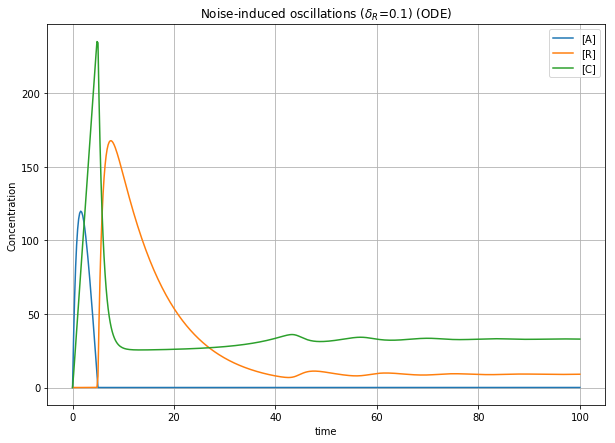

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc

fig_reaction = plt.figure(figsize=(10,7))

label = [r'[A]',r'[R]',r'[C]']
for i in range(wsol.shape[1]):
    plt.plot(t,wsol[:,i], label=label[i])

plt.legend()
plt.grid()
plt.title('Noise-induced oscillations ($\delta_R$=0.1) (ODE)')
plt.xlabel('time')
plt.ylabel('Concentration')

### Simulate and Plot deterministic simulation ($\delta_R = 0.2$)

Text(0,0.5,'Concentration')

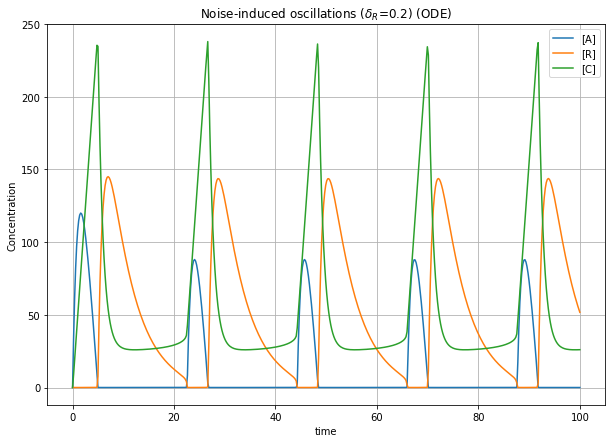

In [10]:
# Set parameters
param2 = {
    'N':[0,0,0],
    'K':[250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.2]
}

# Solve ODE
wsol2 = odeint(deterministic_reaction, param['N'], t, args=(param2['K'],)
              , atol=abserr, rtol=relerr)

# Plot
fig_reaction = plt.figure(figsize=(10,7))
label = [r'[A]',r'[R]',r'[C]']
for i in range(wsol2.shape[1]):
    plt.plot(t,wsol2[:,i], label=label[i])
    
plt.legend()
plt.grid()
plt.title('Noise-induced oscillations ($\delta_R$=0.2) (ODE)')
plt.xlabel('time')
plt.ylabel('Concentration')

### Conclustion of 1.(b):

1. Does the system exhibit oscillation?
    * This system doesn't oscillate and decays when $\delta_R=0.1$. However, it oscillates when $\delta_R=0.2$



## 1.(c) Properties of Initial conditions

<img src = "img/hw5_p1c.png">

Text(0,0.5,'Concentration')

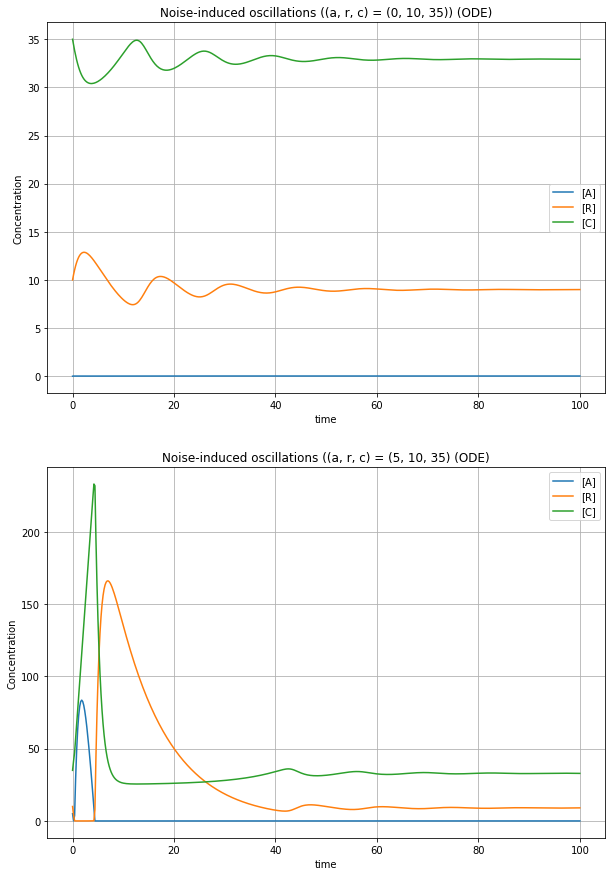

In [11]:
param3 = {
    'N':[0,10,35],
    'K':[250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.1]
}

param4 = {
    'N':[5,10,35],
    'K':[250, 5, 0.5, 0.1, 1, 50, 10, 1, 200, 0.1]
}

t_max = 100.0
t = np.linspace(0, t_max, numpoints)

# Solve ODE
wsol3 = odeint(deterministic_reaction, param3['N'], t, args=(param3['K'],)
              , atol=abserr, rtol=relerr)

wsol4 = odeint(deterministic_reaction, param4['N'], t, args=(param4['K'],)
              , atol=abserr, rtol=relerr)

plt.figure(figsize=(10,15))
# Plot 3
plt.subplot(211)
#fig_reaction = plt.figure(figsize=(10,7))
label = [r'[A]',r'[R]',r'[C]']
for i in range(wsol3.shape[1]):
    plt.plot(t,wsol3[:,i], label=label[i])
    
plt.legend()
plt.grid()
plt.title('Noise-induced oscillations ((a, r, c) = (0, 10, 35)) (ODE)')
plt.xlabel('time')
plt.ylabel('Concentration')

# Plot 4
plt.subplot(212)
#fig_reaction = plt.figure(figsize=(10,7))
label = [r'[A]',r'[R]',r'[C]']
for i in range(wsol4.shape[1]):
    plt.plot(t,wsol4[:,i], label=label[i])
    
plt.legend()
plt.grid()
plt.title('Noise-induced oscillations ((a, r, c) = (5, 10, 35) (ODE)')
plt.xlabel('time')
plt.ylabel('Concentration')

## Conclusion of 1.(c)

With parameter $\delta_R=0.1$

1. When $[A]_{t=0}=0$, there is no oscillation, and $[R]$, $[C]$ converge.

2. When $[A]_{t=0}=5$, there is only one spike in the beginning, then all of variables converge.

3. With higher $\delta_{R}$, the repressor decreases faster, and then possibly unlock activator $[A]$, inducing spikes.